In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers

In [5]:
df = pd.read_csv('diabetes.csv')

In [6]:
correlations = df.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [7]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [8]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [9]:
class DiabetesPredictor:
    def __init__(self, df, name, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumns=[], columnsToRemove=[]):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.


    Attributes:
        replace_outliers: Use the string "replace_outliers" if you want to do that on your model with the median value
        replace_nulls: Use the string "replace_nulls" to replace all nulls in your model with the median value
        delete_row_with_outliers: Use the string "delete_row_with_outliers" to replace all the rows that contains outliers
    """
        self.df = df
        self.name = name
        if(replaceOutliers):
            self.__replace_outliers__(outliersColumns)
        elif(deleteRowsWithOutliers): 
            self.__delete_row_with_outliers__(outliersColumns)
        if(replaceNulls):
            self.__replace_nulls__(nullColumns)
        elif (deleteRowsWithNulls):
            self.__delete_row_with_nulls__(nullColumns)
        
        self.__remove_columns__(columnsToRemove)
        self.__separate_data_and_labels__()
        self.__normalize_data__()
        self.__split_train_test__()
        self.__find_best_hyperparams__()
        
    def __separate_data_and_labels__(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)
    
    def __replace_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = get_outliers_limits(col)
            #Reemplazo.
            for i in self.df[col[0]]:
                if i > Upper_val or i < Lower_val:
                    self.df[col] = self.df[col].replace(i, med)

    def __get_outliers_limits(self, col, want_med = True):
        #Cálculo de parámetros para obtener los outliers.
        q1 = self.df[col[0]].quantile(0.25)
        q3 = self.df[col[0]].quantile(0.75)
        iqr = q3-q1
        #Límites de los valores tipicos.
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        Lower_val = min(Lower_tail, col[1])
        Upper_val = max(Upper_tail, col[2])
        #Cálculo de la mediana.
        med = np.median(self.df[col[0]])
        if(want_med == True):
            return Upper_val, Lower_val, med
        else:
            return Upper_val, Lower_val

    def __replace_nulls__(self, cols):
        columns = cols
        self.df[columns] = self.df[columns].replace(0,np.NaN)
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def __remove_columns__(self, cols):
        self.df = self.df.drop(cols, axis=1)
    
    def __normalize_data__(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std

    def __split_train_test__(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def __model_builder__(self,hp):
        model = Sequential()
        model.add(Dense(1,activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __find_best_hyperparams__(self):
        self.tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        self.tuner.search(self.x_train, self.y_train, epochs=100, validation_split=0.2)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def get_best_hyperparams(self):
        return 'Learning Rate: ' + str(self.best_hps.get('learning_rate')) + '   --   Momentum: ' + str(self.best_hps.get('momentum'))

    def train_model(self):
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=100, validation_split=0.2, verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=best_epoch, validation_split=0.2)

    def test_model(self):
        self.predictions = self.hypermodel.predict(self.x_test)
        self.fpr_keras, self.tpr_keras, self.thresholds_keras = roc_curve(self.y_test, self.predictions)
        self.auc_keras = auc(self.fpr_keras, self.tpr_keras)
        return self.auc_keras

    def plot_roc(self):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_keras, self.tpr_keras, label='Keras (area = {:.3f})'.format(self.auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('AUC ' + str(self.auc_keras))
        rounded_preds = np.rint(self.predictions)
        print('Specificity: ' + str(specificity(self.y_test.astype(float),  rounded_preds.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_test.astype(float),  rounded_preds.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_test.astype(float), rounded_preds.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_test.astype(float), rounded_preds.astype(float))))
    
    def __delete_row_with_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = get_outliers_limits(col, want_med = False)

            self.df = self.df[Lower_val < self.df[col[0]] < Upper_val]

    def __delete_row_with_nulls__(self, cols):
        for col in cols:
            self.df = self.df[self.df[col] != np.NaN]

In [10]:
predictor = DiabetesPredictor(df,'predictor')

INFO:tensorflow:Reloading Oracle from existing project saved_models\predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [143]:
predictor.get_best_hyperparams()

'Learning Rate: 0.1   --   Momentum: 0.9'

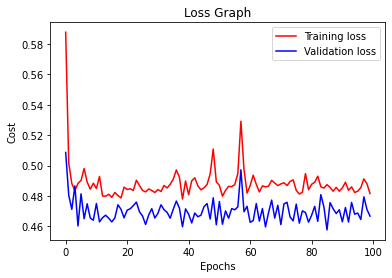

Best epoch: 86
Epoch 1/86
18/18 [==============================] - 1s 17ms/step - loss: 0.7075 - auc: 0.6622 - val_loss: 0.5068 - val_auc: 0.8359
Epoch 2/86
18/18 [==============================] - 0s 2ms/step - loss: 0.5392 - auc: 0.8156 - val_loss: 0.5104 - val_auc: 0.8344
Epoch 3/86
18/18 [==============================] - 0s 2ms/step - loss: 0.4986 - auc: 0.8274 - val_loss: 0.4583 - val_auc: 0.8484
Epoch 4/86
18/18 [==============================] - 0s 2ms/step - loss: 0.4908 - auc: 0.8259 - val_loss: 0.4704 - val_auc: 0.8447
Epoch 5/86
18/18 [==============================] - 0s 2ms/step - loss: 0.4912 - auc: 0.8190 - val_loss: 0.4711 - val_auc: 0.8527
Epoch 6/86
18/18 [==============================] - 0s 2ms/step - loss: 0.4848 - auc: 0.8339 - val_loss: 0.4690 - val_auc: 0.8426
Epoch 7/86
18/18 [==============================] - 0s 3ms/step - loss: 0.4870 - auc: 0.8288 - val_loss: 0.4608 - val_auc: 0.8489
Epoch 8/86
18/18 [==============================] - 0s 4ms/step - loss: 0.

In [144]:
predictor.train_model()

In [145]:
auc_pred = predictor.test_model()
print('AUC: ' + str(auc_pred))

AUC: 0.8238993710691824


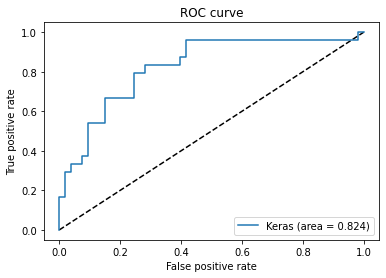

In [146]:
predictor.plot_roc()

In [147]:
predictor.get_metrics()

AUC 0.8238993710691824
Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5833333309027777, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6363636334710744, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8181818166942149, shape=(), dtype=float64)


## Limpiando Datos

#### Reemplazando Nulls por la mediana

Trial 20 Complete [00h 00m 04s]
val_loss: 0.49740755558013916

Best val_loss So Far: 0.4529326955477397
Total elapsed time: 00h 01m 41s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


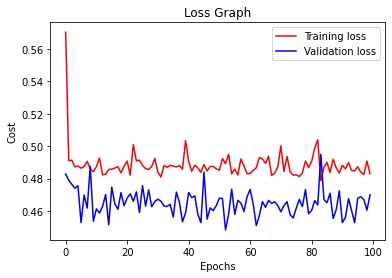

Best epoch: 53
Epoch 1/53
18/18 [==============================] - 1s 15ms/step - loss: 0.5693 - auc: 0.7571 - val_loss: 0.4823 - val_auc: 0.8445
Epoch 2/53
18/18 [==============================] - 0s 2ms/step - loss: 0.5013 - auc: 0.8310 - val_loss: 0.4652 - val_auc: 0.8458
Epoch 3/53
18/18 [==============================] - 0s 4ms/step - loss: 0.4893 - auc: 0.8247 - val_loss: 0.4716 - val_auc: 0.8506
Epoch 4/53
18/18 [==============================] - 0s 2ms/step - loss: 0.4897 - auc: 0.8240 - val_loss: 0.4638 - val_auc: 0.8579
Epoch 5/53
18/18 [==============================] - 0s 2ms/step - loss: 0.4874 - auc: 0.8301 - val_loss: 0.4704 - val_auc: 0.8508
Epoch 6/53
18/18 [==============================] - 0s 2ms/step - loss: 0.4877 - auc: 0.8263 - val_loss: 0.4761 - val_auc: 0.8422
Epoch 7/53
18/18 [==============================] - 0s 2ms/step - loss: 0.4945 - auc: 0.8218 - val_loss: 0.4549 - val_auc: 0.8595
Epoch 8/53
18/18 [==============================] - 0s 2ms/step - loss: 0.

In [148]:
predictorRepNulls = DiabetesPredictor(df,'rep_nulls_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])
predictorRepNulls.train_model()
aucRepNulls = predictorRepNulls.test_model()
print('AUC: ' + str(aucRepNulls))

In [149]:
predictorRepNulls.get_best_hyperparams()

'Learning Rate: 0.1   --   Momentum: 0.9'

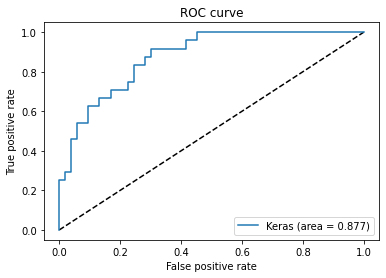

AUC 0.8773584905660377
Specificity: tf.Tensor(0.8679245266642933, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6249999973958333, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6818181787190083, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8363636348429752, shape=(), dtype=float64)


In [150]:
predictorRepNulls.plot_roc()
predictorRepNulls.get_metrics()

#### Removiendo Nulls

Trial 26 Complete [00h 00m 07s]
val_loss: 0.6098669370015463

Best val_loss So Far: 0.4466959734757741
Total elapsed time: 00h 02m 43s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


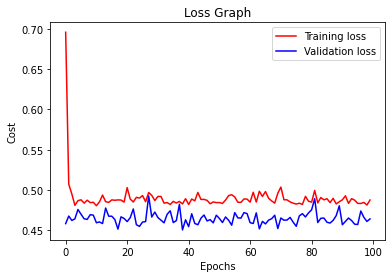

Best epoch: 39
Epoch 1/39
18/18 [==============================] - 1s 17ms/step - loss: 0.5692 - auc: 0.7838 - val_loss: 0.4531 - val_auc: 0.8568
Epoch 2/39
18/18 [==============================] - 0s 2ms/step - loss: 0.4879 - auc: 0.8306 - val_loss: 0.4741 - val_auc: 0.8513
Epoch 3/39
18/18 [==============================] - 0s 3ms/step - loss: 0.4833 - auc: 0.8325 - val_loss: 0.4790 - val_auc: 0.8420
Epoch 4/39
18/18 [==============================] - 0s 2ms/step - loss: 0.4808 - auc: 0.8306 - val_loss: 0.4667 - val_auc: 0.8576
Epoch 5/39
18/18 [==============================] - 0s 2ms/step - loss: 0.4842 - auc: 0.8301 - val_loss: 0.4661 - val_auc: 0.8528
Epoch 6/39
18/18 [==============================] - 0s 5ms/step - loss: 0.4868 - auc: 0.8293 - val_loss: 0.4629 - val_auc: 0.8541
Epoch 7/39
18/18 [==============================] - 0s 3ms/step - loss: 0.4832 - auc: 0.8281 - val_loss: 0.4687 - val_auc: 0.8517
Epoch 8/39
18/18 [==============================] - 0s 3ms/step - loss: 0.

In [151]:
predictorRemNulls = DiabetesPredictor(df,'rem_nulls_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])
predictorRemNulls.train_model()
aucRemNulls = predictorRemNulls.test_model()
print('AUC: ' + str(aucRemNulls))

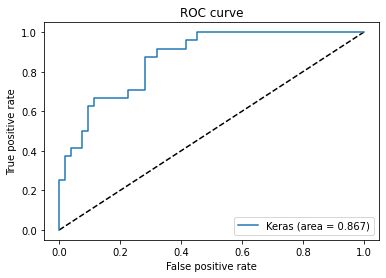

AUC 0.8671383647798742
Specificity: tf.Tensor(0.8867924511569953, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7272727239669421, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8545454529917356, shape=(), dtype=float64)


In [152]:
predictorRemNulls.plot_roc()
predictorRemNulls.get_metrics()

#### Removiendo Columnas

Trial 22 Complete [00h 00m 06s]
val_loss: 0.4859182933966319

Best val_loss So Far: 0.4843600591023763
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


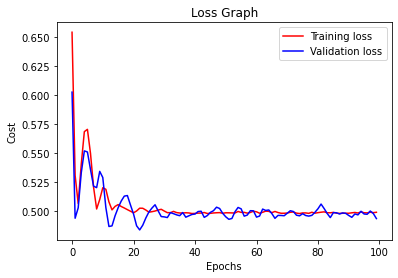

Best epoch: 23
Epoch 1/23
18/18 [==============================] - 1s 18ms/step - loss: 1.0140 - auc: 0.3674 - val_loss: 0.7518 - val_auc: 0.5304
Epoch 2/23
18/18 [==============================] - 0s 3ms/step - loss: 0.6401 - auc: 0.6455 - val_loss: 0.4864 - val_auc: 0.8315
Epoch 3/23
18/18 [==============================] - 0s 2ms/step - loss: 0.5135 - auc: 0.8085 - val_loss: 0.5610 - val_auc: 0.8034
Epoch 4/23
18/18 [==============================] - 0s 2ms/step - loss: 0.5877 - auc: 0.8060 - val_loss: 0.7015 - val_auc: 0.7796
Epoch 5/23
18/18 [==============================] - 0s 2ms/step - loss: 0.6676 - auc: 0.8010 - val_loss: 0.7896 - val_auc: 0.7675
Epoch 6/23
18/18 [==============================] - 0s 3ms/step - loss: 0.7059 - auc: 0.7991 - val_loss: 0.8051 - val_auc: 0.7662
Epoch 7/23
18/18 [==============================] - 0s 3ms/step - loss: 0.6981 - auc: 0.7997 - val_loss: 0.7625 - val_auc: 0.7754
Epoch 8/23
18/18 [==============================] - 0s 3ms/step - loss: 0.

In [153]:
predictorRemCols = DiabetesPredictor(df,'rem_cols_predictor' ,replaceNulls=True, nullColumns=['Glucose','BMI'], columnsToRemove=['BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age'])
predictorRemCols.train_model()
aucRemCols = predictorRemCols.test_model()
print('AUC: ' + str(aucRemCols))

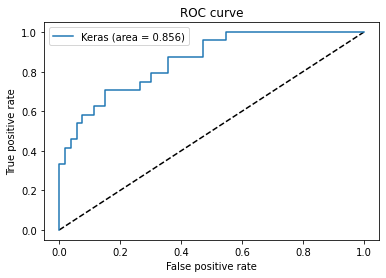

AUC 0.8561320754716981
Specificity: tf.Tensor(0.8867924511569953, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6249999973958333, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7142857108843537, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)


In [154]:
predictorRemCols.plot_roc()
predictorRemCols.get_metrics()